In [1]:
import os
import numpy as np
import pydicom
import pandas as pd
import re
from warnings import warn
import parsing
from task1 import get_slice_set, read_slice_with_annotations
# from torch.utils.data import Dataset, DataLoader

In [2]:
from task2 import HeartDataset
from task4 import crop, crop_roi
from task4 import threshold_otsu_histogram, circle
from task4 import intersection_over_union, masked_otsu, threshold_i_contour

In [3]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
dir_data = 'final_data'
fn_link = f'{dir_data}/link.csv'

metadata = pd.read_csv(fn_link)
print( f'{metadata.shape[0]} series parsed')

filenames = get_slice_set(metadata, dir_data, o_contours=True, join='inner')
print( f'{filenames.shape[0]} files parsed')

5 series parsed
46 files parsed


/Users/dlituiev/repos/assigments/task1.py:107: UserWarning: some dicom slices are missing: 9 matches out of 18 contours
  f'matches out of {filenames_i_contour.shape[0]} contours')
/Users/dlituiev/repos/assigments/task1.py:107: UserWarning: some dicom slices are missing: 10 matches out of 20 contours
  f'matches out of {filenames_i_contour.shape[0]} contours')
/Users/dlituiev/repos/assigments/task1.py:107: UserWarning: some dicom slices are missing: 9 matches out of 22 contours
  f'matches out of {filenames_i_contour.shape[0]} contours')


# instatiate a HeartDataset

In [6]:
hdset = HeartDataset(filenames, with_contour=True)
sample = hdset[35]

## read and visualize a contour and its mask

In [7]:
ocontour = np.asarray(sample['ocontour'], dtype=int)
# ocontour[:,0].max()
# ocontour[:,0].min()
bbox = cv2.boundingRect(ocontour)
bbox

(100, 104, 45, 43)

(104, 147)

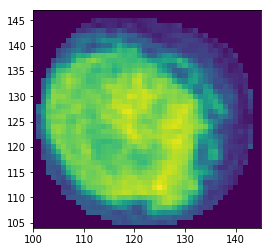

In [8]:
plt.imshow(sample['image'] * sample['omask'].astype(np.uint8))
plt.xlim(bbox[0], bbox[0]+bbox[2])
plt.ylim(bbox[1], bbox[1]+bbox[3])

## Descriptive statistics and sanity check:
- calculate set difference for pixels: | {i} \ {o} | -- must be zero
- calculate IoU for thresholding method
- width and height of o-contour bounding boxes -- can be useful for machine learning approaches

In [137]:
for ii, sample in enumerate(hdset):
    hdset.filenames.loc[ii, 'i_out_of_o'] = ((sample['imask'] ^ sample['omask']) & sample['imask']).sum()
    
    image_muscle_pool = sample['image'][sample['omask']]
    histo = np.bincount(image_muscle_pool)
    thr = threshold_otsu_histogram(histo)
    sample_ithr = threshold_i_contour(sample, thr, ker_size=3, mode='dilate')
    hdset.filenames.loc[ii, 'iou'] = intersection_over_union(sample_ithr['imask'], sample['imask'])
    
    # try some hyperparameters
    sample_ithr = threshold_i_contour(sample, thr, ker_size=3, mode='dilate', 
                                      prefilter_fn=lambda x: cv2.medianBlur(x, 3))
    hdset.filenames.loc[ii, 'iou_modified'] = intersection_over_union(sample_ithr['imask'], sample['imask'])
    
    bbox = cv2.boundingRect(np.asarray(sample['ocontour'], dtype=int))
    hdset.filenames.loc[ii, 'width'] = bbox[2]
    hdset.filenames.loc[ii, 'height'] = bbox[3]

### Improvement due to a new hyperparameter set

-0.04415064579821281

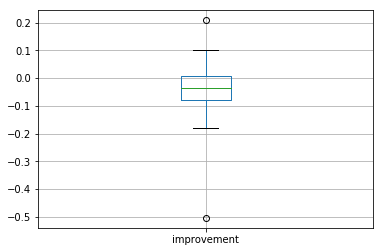

In [138]:
improvement = hdset.filenames['iou_modified'] - hdset.filenames['iou']
improvement.name='improvement'
improvement.to_frame().boxplot() 
improvement.mean()

In [163]:
valid_iou = hdset.filenames[hdset.filenames.original_id!='SC-HF-I-6'].iou
'IoU = {:4f} +/- {:4f}'.format(valid_iou.mean(), valid_iou.std()/np.sqrt(len(valid_iou)))

'IoU = 0.808225 +/- 0.017279'

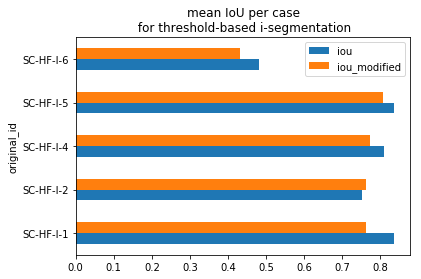

In [124]:
hdset.filenames.groupby('original_id')[['iou', 'iou_modified']].mean().plot(kind='barh')
plt.title('mean IoU per case\n for threshold-based i-segmentation')
pass

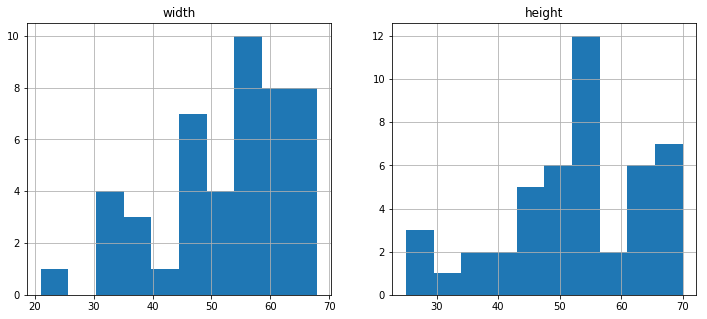

In [66]:
# hdset.filenames.iloc[ii, 'width']
fig, axs = plt.subplots(1,2, figsize = (12,5))
for ii, x in enumerate(['width', 'height']):
    hdset.filenames[x].hist(ax=axs[ii])
    axs[ii].set_title(x)

## Investigate the source of error `| {i} \ {o} | > 0`

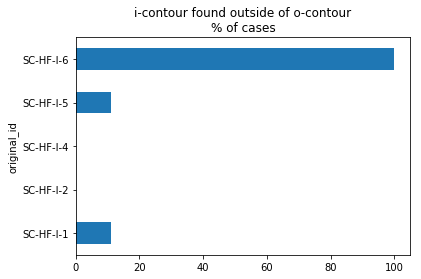

In [141]:
hdset.filenames.groupby('original_id')['i_out_of_o'].agg(lambda x: 100*np.mean(x>0)).plot(kind='barh')
plt.title('i-contour found outside of o-contour\n% of cases')
plt.savefig('icontour_outside_ocontour.png',)
pass

In [69]:
# sum(np.asarray(i_out_of_os) <= 100)
from collections import Counter
import pandas as pd
hdset.filenames['i_out_of_o'].value_counts().sort_index()

0.0      35
1.0       1
3.0       1
214.0     1
261.0     1
337.0     1
389.0     1
443.0     1
447.0     1
465.0     1
496.0     1
501.0     1
Name: i_out_of_o, dtype: int64

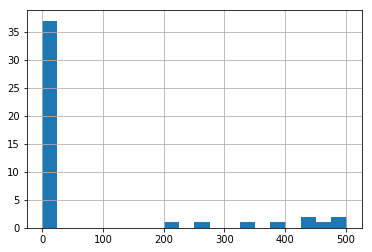

In [70]:
hdset.filenames['i_out_of_o'].hist(bins=20)
pass

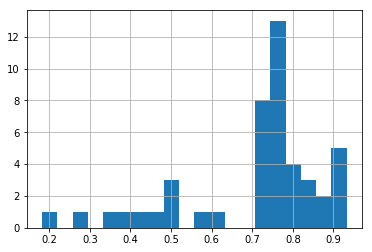

In [71]:
hdset.filenames['iou'].hist(bins=20)
pass

In [72]:
# plt.imshow(np.logical_and(sample_ithr['imask'], sample['imask']))

## Inspect thresholding on a single case

In [161]:
# SC-HF-I-1
mask = (hdset.filenames.original_id=='SC-HF-I-1') & (hdset.filenames.slice_id == 139)
# mask.idxmax()

In [145]:
sample = hdset[0]

image_muscle_pool = sample['image'][sample['omask']]
mask_muscle = sample['omask']*~sample['imask']
mask_pool = sample['omask']*sample['imask']

## find a bounding box for o-contour for close-up visualization
ocontour = np.asarray(sample['ocontour'], dtype=int)
bbox = cv2.boundingRect(ocontour)
bbox

(103, 111, 54, 54)

### Histograms

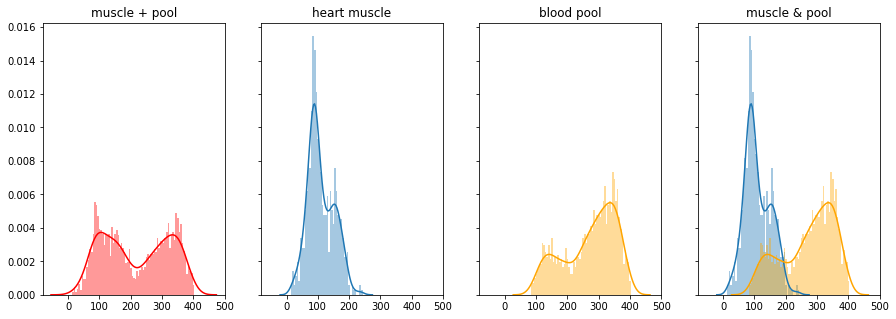

In [146]:
fig, axs = plt.subplots(1,4, figsize=(15,5), sharex=True, sharey=True)

bins = np.arange(image_muscle_pool.min(), image_muscle_pool.max(), 5)
rug_kws={'alpha':0.2},

sns.distplot(image_muscle_pool,
                  rug_kws=rug_kws,
                  bins=bins,
                  ax= axs[0],
                 color='red',
                 )
axs[0].set_title('muscle + pool')

sns.distplot(sample['image'][mask_muscle],
                  rug_kws=rug_kws,
                  bins=bins,
                  ax= axs[1]
                 )
axs[1].set_title('heart muscle')

sns.distplot(sample['image'][mask_pool],
                  rug_kws=rug_kws,
                  bins=bins,
                  ax= axs[2],
                  color='orange',
                 )
axs[2].set_title('blood pool')

ax = sns.distplot(sample['image'][mask_muscle],
                  rug_kws=rug_kws,
                  bins=bins,
                  ax= axs[3]
                 )

ax = sns.distplot(sample['image'][mask_pool],
                  rug_kws=rug_kws,
                  bins=bins,
                  ax= axs[3],
                  color='orange',
                 )

axs[3].set_title('muscle & pool')
plt.savefig('i_o_histograms.png',)
pass

### Close-up

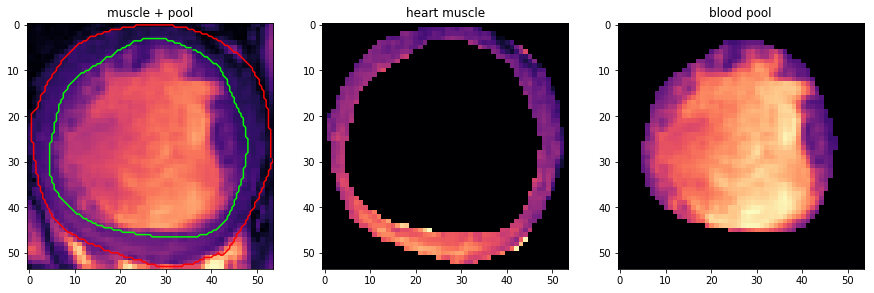

In [147]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(crop(bbox, 
                   sample['image'] #* sample['omask'].astype(np.uint8)
               ), cmap='magma')

icontour = crop_roi(bbox, sample['icontour'])
ocontour = crop_roi(bbox, sample['ocontour'])

axs[0].plot(icontour[:,0],
            icontour[:,1], c='lime')


axs[0].plot(ocontour[:,0],
            ocontour[:,1], c='r')

axs[0].set_title('muscle + pool')

axs[1].imshow(crop(bbox,
                   sample['image'] * (mask_muscle).astype(np.uint8)
               ), cmap='magma')
axs[1].set_title('heart muscle')


axs[2].imshow(crop(bbox,
                   sample['image'] * (mask_pool).astype(np.uint8)
               ), cmap='magma')
axs[2].set_title('blood pool');
plt.savefig('closeup.png',)

### Entire slice

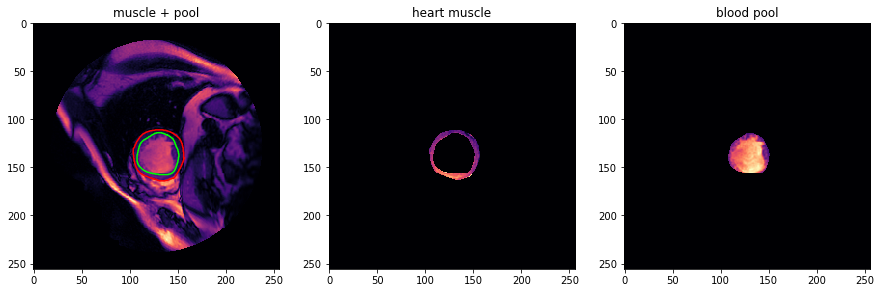

In [76]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(sample['image'],
              cmap='magma')

icontour = np.asarray(sample['icontour'])
ocontour = np.asarray(sample['ocontour'])

axs[0].plot(icontour[:,0],
            icontour[:,1], c='lime')

axs[0].plot(ocontour[:,0],
            ocontour[:,1], c='r')

axs[0].set_title('muscle + pool')

axs[1].imshow(sample['image'] * (mask_muscle).astype(np.uint8),
               cmap='magma')
axs[1].set_title('heart muscle')

axs[2].imshow(sample['image'] * (mask_pool).astype(np.uint8),
              cmap='magma')
axs[2].set_title('blood pool');
# plt.savefig('')

### Perform thresholding on an example image

threshold: 219


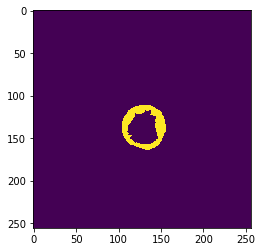

In [150]:
image_muscle_pool = sample['image'][sample['omask']]
histo = np.bincount(image_muscle_pool)
thr = threshold_otsu_histogram(histo)
print('threshold:', thr)

mask_thr_muscle = (sample['image']<thr) * (sample['omask'])
plt.imshow(mask_thr_muscle)

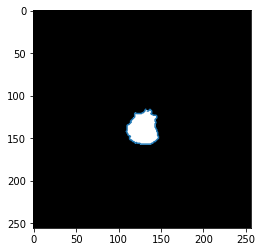

In [151]:
sample_ithr = threshold_i_contour(sample, thr, ker_size=3, mode='dilate')

icontour = crop_roi(bbox, sample['icontour'])
ocontour = crop_roi(bbox, sample['ocontour'])
icontour_thr = crop_roi(bbox, sample_ithr['icontour'])

plt.imshow(sample_ithr['imask'], cmap='gray')
plt.plot(sample_ithr['icontour'][:,0], 
         sample_ithr['icontour'][:,1],)

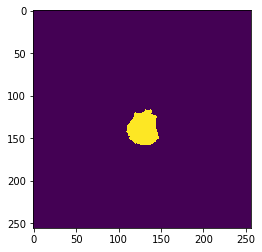

In [152]:
mask_thr_ventr = np.zeros_like(sample_ithr['imask']).astype(np.uint8)
mask_thr_ventr = cv2.drawContours(mask_thr_ventr, [sample_ithr['icontour']], 0, 1, -1)
plt.imshow(mask_thr_ventr)

In [153]:
# histo = np.bincount(im_ventricule.ravel())
# thr = threshold_otsu_histogram(histo)
# thr

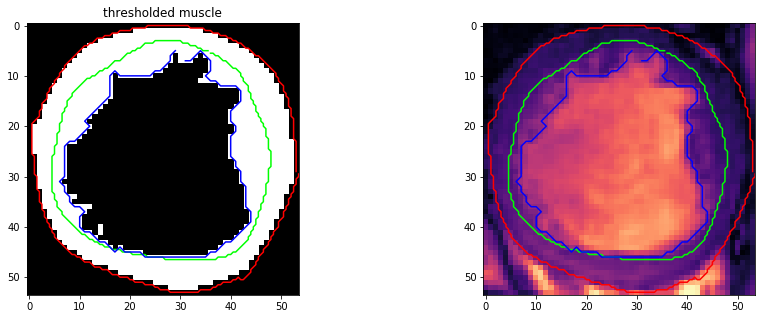

In [154]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
ax = axs[0]
ax.imshow(crop(bbox, 
                   mask_thr_muscle
               ),
         cmap='gray')

ax.plot(icontour[:,0],
        icontour[:,1], c='lime')
ax.plot(ocontour[:,0],
        ocontour[:,1], c='r')
ax.plot(icontour_thr[:,0],
        icontour_thr[:,1],
        c='b')
ax.set_title('thresholded muscle')

ax = axs[1]
ax.imshow(crop(bbox, 
                sample['image']
               ), cmap='magma')

ax.plot(icontour[:,0],
        icontour[:,1], c='lime')
ax.plot(ocontour[:,0],
        ocontour[:,1], c='r')
ax.plot(icontour_thr[:,0],
        icontour_thr[:,1],
        c='b')
# plt.imshow(crop(bbox, mask_thr_muscle))

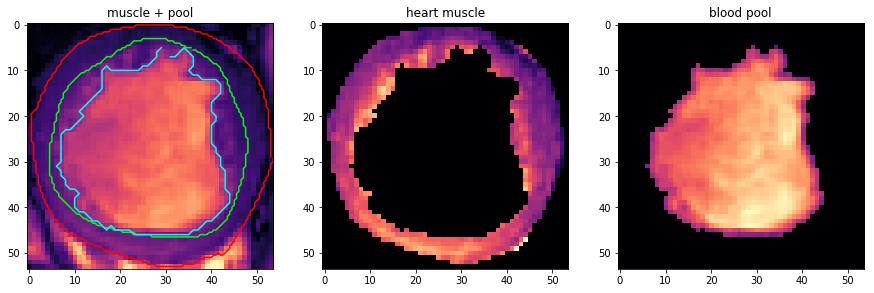

In [155]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(crop(bbox, 
                   sample['image'] #* sample['omask'].astype(np.uint8)
               ), cmap='magma')

icontour = crop_roi(bbox, sample['icontour'])
ocontour = crop_roi(bbox, sample['ocontour'])
mask_muscle_thr = sample['omask']*(~sample_ithr['imask'])

axs[0].plot(icontour[:,0],
            icontour[:,1], c='lime')

axs[0].plot(ocontour[:,0],
            ocontour[:,1], c='r')

axs[0].plot(icontour_thr[:,0],
        icontour_thr[:,1],
        c='cyan')

axs[0].set_title('muscle + pool')

axs[1].imshow(crop(bbox,
                   sample['image'] * (mask_muscle_thr).astype(np.uint8)
               ), cmap='magma')
axs[1].set_title('heart muscle')


axs[2].imshow(crop(bbox,
                   sample['image'] * (sample_ithr['imask']).astype(np.uint8)
               ), cmap='magma')
axs[2].set_title('blood pool');
plt.savefig('closeup_thresholded.png',)